In [102]:
import os

import analysis_plotting_helper_functions_c3 as helper
import analysis_utils as utils

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


In [103]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", 
          "#beb9db", "#fdcce5", "#8bd3c7"]
continuous_colors = ["#54bebe", "#76c8c8", "#98d1d1", "#badbdb", "#dedad2", 
                     "#e4bcad", "#df979e", "#d7658b", "#c80064"]
custom_palette = {'l': colors[1], 's': colors[0]}

In [104]:
cohort = 'cohort_3'
to_analyze = 'full_clean'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
data_folder = os.path.join(data_dir, cohort, to_analyze)
figure_folder = os.path.join(data_dir, cohort, 'figures')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/full_clean
/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/figures


# Session based plotting

### load session log

In [105]:
training_session_log = utils.load_session_log(data_folder, 'training_sessions.csv')

make mouse list

In [106]:
mouse_list = utils.generate_mouse_list(training_session_log)

['RZ018', 'RZ019', 'RZ020', 'RZ021', 'RZ022', 'RZ023', 'RZ024', 'RZ025']


### Add session type 
shoudl be moved to the previous nb

In [107]:
def get_session_tb(all_trials):
    bg_length = all_trials.bg_length.mean()
    if bg_length <= 2:
        session_type = 's'
    elif bg_length > 2:
        session_type = 'l'
    return [session_type, bg_length]

In [108]:
for dir_name in training_session_log.dir:
    all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
    # time waited for all trials
    bg_info = get_session_tb(all_trials)
    training_session_log.loc[training_session_log.dir == dir_name, 
                                ['session_type', 'bg_length']] = bg_info

### checking if there are mixed long and short sessions between the two cohorts

In [109]:
short_list = ['RZ018', 'RZ019', 'RZ022', 'RZ023']
long_list = ['RZ020', 'RZ021', 'RZ024', 'RZ025']

In [110]:
for m in short_list:
    short_df = training_session_log.loc[training_session_log.mouse == m]
    session_type_list = short_df.session_type.unique().tolist()
    if len(session_type_list) == 1:
        print(m)

RZ018
RZ019
RZ022
RZ023


In [111]:
for m in long_list:
    short_df = training_session_log.loc[training_session_log.mouse == m]
    session_type_list = short_df.session_type.unique().tolist()
    if len(session_type_list) == 1:
        print(m)

RZ020
RZ021
RZ024
RZ025


### Plotting functions
should be moved to helper

In [112]:
def plot_each_mouse_per_line(data_df, column_name, plot_name, title, x_label, y_label, 
                             figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    for i, mouse in enumerate(mouse_list):
        session_mouse = data_df.loc[data_df.mouse == mouse]
        plt.plot(session_mouse.session_num, session_mouse[column_name], color=colors[i], label=mouse)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [113]:
def plot_overdays_colored_by_group(data_df, column_name, plot_name, title, x_label, y_label, 
                                   figure_folder=figure_folder, mouse_list=mouse_list, color_palette=custom_palette):
    fig = plt.figure()
    sns.lineplot(x="session_num",
                 y=column_name,
                 hue="session_type",
                 data=data_df,
                 palette=color_palette)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

# Plot type of trials per session

### generate trial type df for plotting
Calculate proportions of trials types and generate trial type df

In [114]:
def generate_trial_type_df(training_session_log):
    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        session_performance = helper.get_session_performance(all_trials)
        training_session_log.loc[training_session_log.dir == dir_name, 
                                 ['miss_trials', 'good_trials']] = session_performance
    trial_type_df = training_session_log[['mouse', 'session_type', 'session_num', 'num_trials', 'miss_trials', 'good_trials']].copy()
    trial_type_df['p_miss'] = trial_type_df.miss_trials/trial_type_df.num_trials
    trial_type_df['p_good'] = trial_type_df.good_trials/trial_type_df.num_trials
    trial_type_df['p_accident'] = 1 - trial_type_df.p_good - trial_type_df.p_miss 
    return trial_type_df

In [115]:
trial_type_df = generate_trial_type_df(training_session_log)

### trial type combined plot

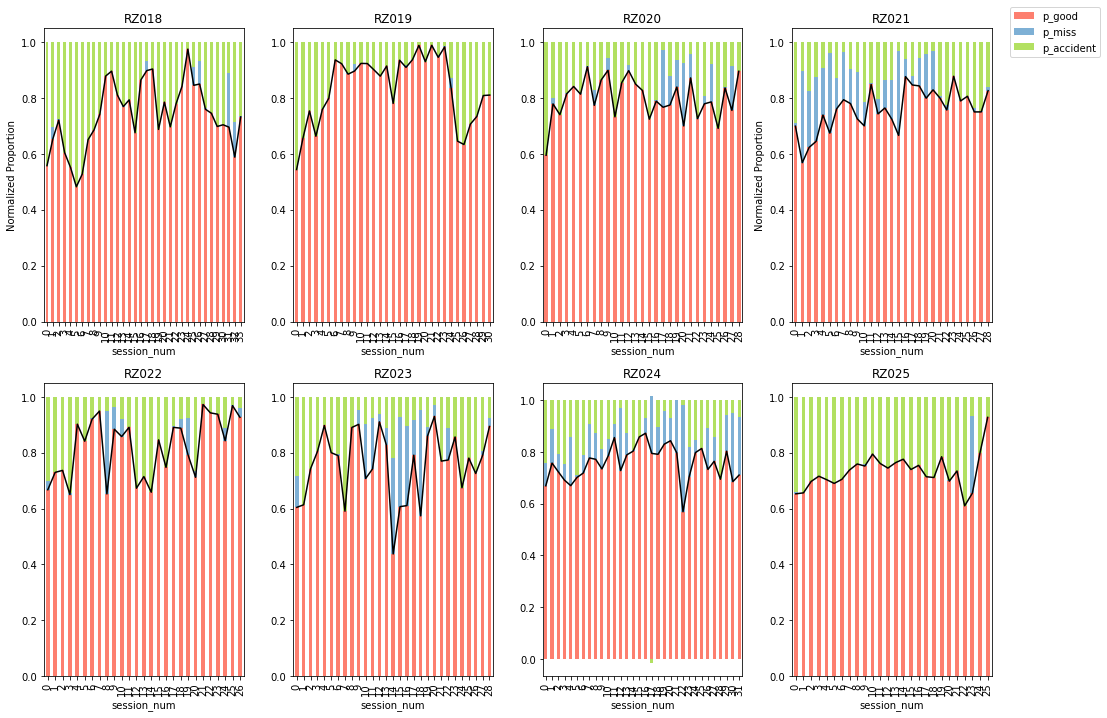

In [116]:
# ploting the proportion of good trials, miss trials, and enl trials per session
fig, axs = plt.subplots(2, 4, figsize=(14, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = trial_type_df.loc[trial_type_df.mouse == mouse]
    to_plot = session_mouse.loc[:, ['session_num', 'p_good', 'p_miss', 'p_accident']]
    ax = axs.flat[i]
    to_plot.plot.bar(x='session_num', stacked=True, color=colors[0:3], ax=ax, legend=None)
    ax.set_title(mouse)
    if i == 0 or i == 3:
        ax.set_ylabel('Normalized Proportion')
    ax.plot(to_plot.session_num, to_plot.p_good, color='k', linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.savefig(f'{figure_folder}/engagement_plots.png', bbox_inches='tight')
plt.show()

### percentage good trials

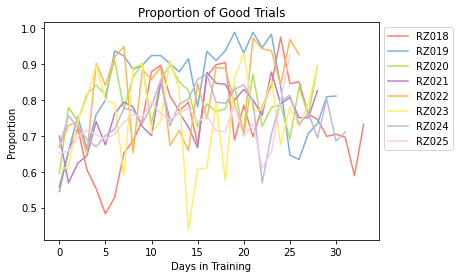

In [117]:
# plot the proportion of good trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_good', 
                         plot_name="%_good_trials", 
                         title='Proportion of Good Trials',
                         x_label='Days in Training', 
                         y_label='Proportion')

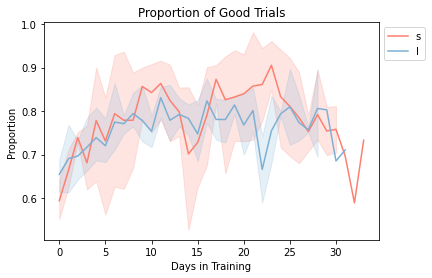

In [118]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_good", 
                               plot_name='%_good_trials_by_group', 
                               title='Proportion of Good Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

### Percent missed trials

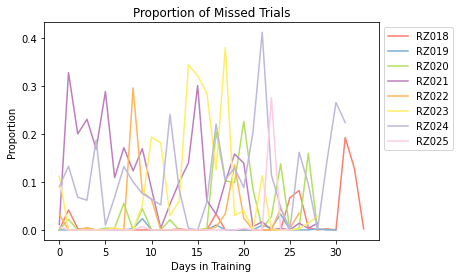

In [119]:
# plot the proportion of miss trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_miss', 
                         plot_name="%_miss_trials",
                         title='Proportion of Missed Trials', 
                         x_label='Days in Training', 
                         y_label='Proportion')

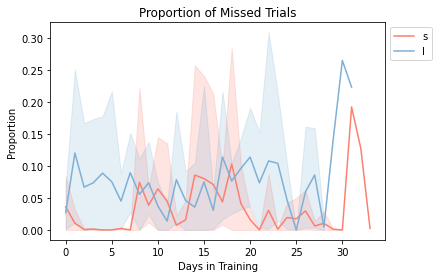

In [120]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_miss", 
                               plot_name='%_miss_trials_by_group', 
                               title='Proportion of Missed Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

### Percent accident trials

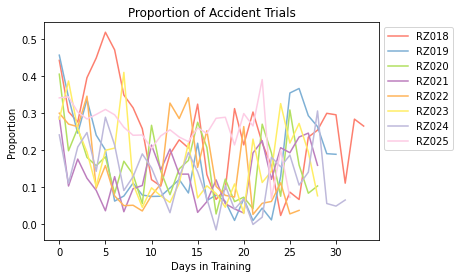

In [121]:
# plot the proportion of accident trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_accident', 
                         plot_name="%_accident_trials", 
                         title='Proportion of Accident Trials',
                         x_label='Days in Training', 
                         y_label='Proportion')

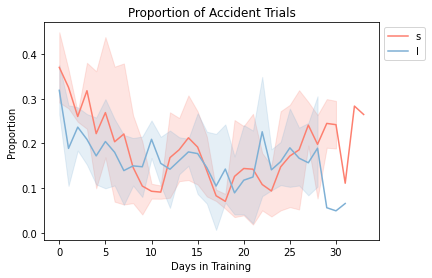

In [122]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_accident", 
                               plot_name='%_accident_trials_by_group', 
                               title='Proportion of Accident Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

# Plot rewards per session

### add info to training session log for plotting

In [123]:
training_session_log['reward_rate'] = training_session_log.rewards/training_session_log.time

In [124]:
training_session_log['reward_per_trial'] = training_session_log.rewards/training_session_log.num_trials

### plot reward size

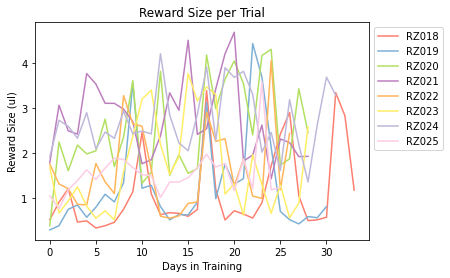

In [125]:
# plot the reward rize
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_per_trial', 
                         plot_name="reward_size",
                         title='Reward Size per Trial', 
                         x_label='Days in Training', 
                         y_label='Reward Size (ul)')

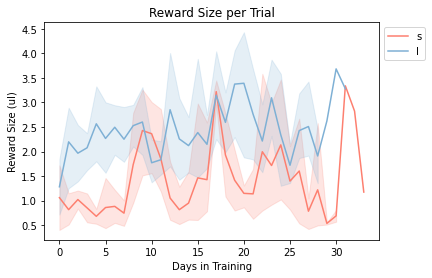

In [126]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_per_trial", 
                               plot_name='reward_size_by_group', 
                               title='Reward Size per Trial', 
                               x_label='Days in Training', 
                               y_label='Reward Size (ul)')

### Plot reward rate

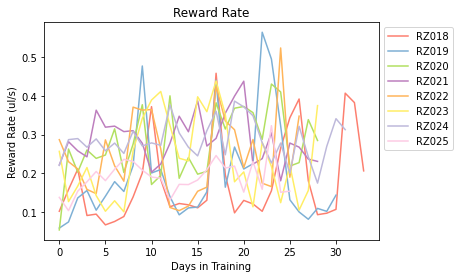

In [127]:
# plot the reward rate
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_rate', 
                         plot_name="reward_rate",
                         title='Reward Rate', 
                         x_label='Days in Training', 
                         y_label='Reward Rate (ul/s)')

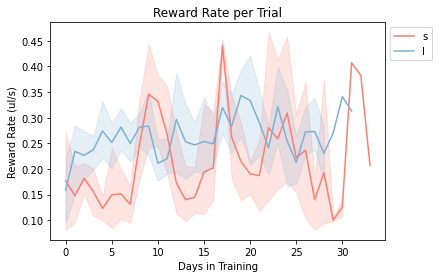

In [128]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_rate", 
                               plot_name='reward_rate_by_group', 
                               title='Reward Rate per Trial', 
                               x_label='Days in Training', 
                               y_label='Reward Rate (ul/s)')

### Plot session length

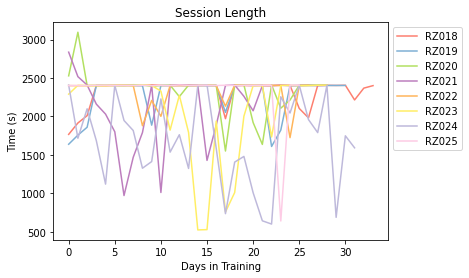

In [129]:
# plot the session length
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='time', 
                         plot_name="session_length", 
                         title='Session Length',
                         x_label='Days in Training', 
                         y_label='Time (s)')

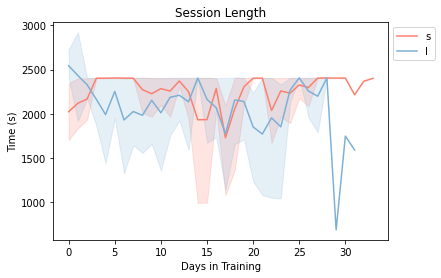

In [130]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="time", 
                               plot_name='session_length_by_group', 
                               title='Session Length', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

### plot num trials completed

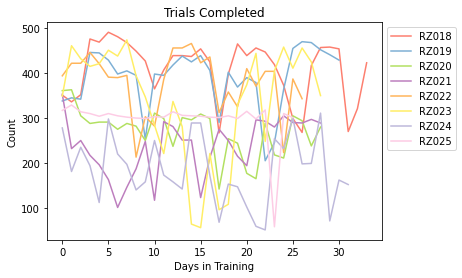

In [131]:
# plot the number of trials completed
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='num_trials', 
                         plot_name="num_trials", 
                         title='Trials Completed',
                         x_label='Days in Training', 
                         y_label='Count')

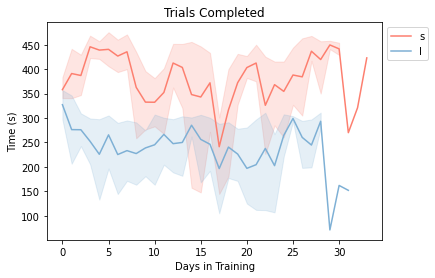

In [132]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="num_trials", 
                               plot_name='num_trials_by_group', 
                               title='Trials Completed', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

# Plot time wait behavior

### generate wait df for plotting

In [133]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session_num', 'dir', 'session_type', 'bg_length']].copy()

    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [134]:
wait_df = generate_wait_df(training_session_log)

### plot time watied

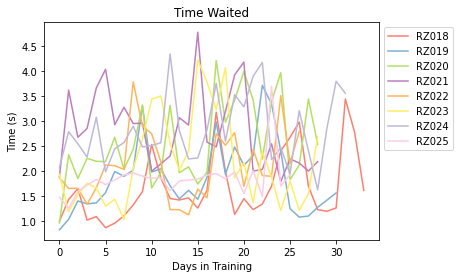

In [135]:
# plot the time waited over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean', 
                         plot_name="tw_mean", 
                         title='Time Waited',
                         x_label='Days in Training', 
                         y_label='Time (s)')

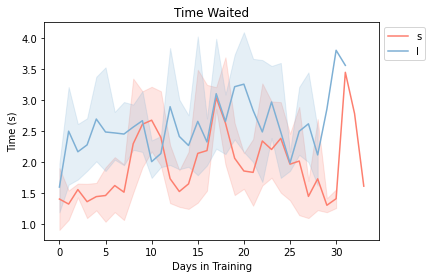

In [136]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean", 
                               plot_name='tw_mean_by_group', 
                               title='Time Waited', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

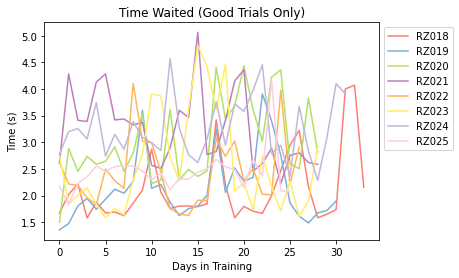

In [137]:
# plot the time waited over days good trials only. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean_g', 
                         plot_name="tw_mean_g", 
                         title='Time Waited (Good Trials Only)',
                         x_label='Days in Training', 
                         y_label='Time (s)')

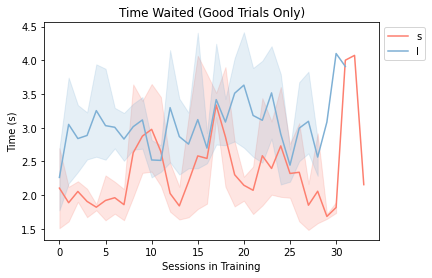

In [138]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean_g", 
                               plot_name='tw_mean_g_by_group', 
                               title='Time Waited (Good Trials Only)', 
                               x_label='Sessions in Training', 
                               y_label='Time (s)')

## some stats

### check if short and long tw are significantly different?
yes for both all trials and good trials only
where should this session go??

In [139]:
short = wait_df[wait_df['session_type']=='s']
long = wait_df[wait_df['session_type']=='l']

#perform independent two sample t-test
ttest_ind(short['tw_mean'], long['tw_mean'])

Ttest_indResult(statistic=-5.798203646368695, pvalue=2.148375940883247e-08)

In [140]:
print(short.tw_mean.mean())
print(long.tw_mean.mean())

1.952321040331175
2.539020623488434


In [141]:
ttest_ind(short['tw_mean_g'], long['tw_mean_g'])

Ttest_indResult(statistic=-7.258621840606357, pvalue=5.675030862659259e-12)

In [142]:
print(short.tw_mean_g.mean())
print(long.tw_mean_g.mean())

2.3196148384906414
3.004510898956198


### check if boys and girls are significantly different
nope they are not different

In [143]:
boys =  ['RZ018', 'RZ019', 'RZ020', 'RZ021']
girls = ['RZ022', 'RZ023', 'RZ024', 'RZ025']

In [144]:
boy = wait_df[wait_df['mouse'].isin(boys)]
girl = wait_df[wait_df['mouse'].isin(girls)]

ttest_ind(boy['tw_mean'], girl['tw_mean'])

Ttest_indResult(statistic=-0.9881441809533065, pvalue=0.32409835034603385)

## linear fit
not so useful for this part

In [145]:
def generate_linear_fit_df(training_session_log):
    linear_fit_df = training_session_log[['mouse', 'session_type', 'session_num', 'dir']].copy()
    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        all_trials = all_trials[all_trials['time_waited'].notna()]
        fit_data = utils.linear_fit(all_trials, 'bg_length', 'time_waited')
        linear_fit_df.loc[linear_fit_df.dir == dir_name, 
                                ['slope', 'intercept', 'rsquared']] = fit_data
    return linear_fit_df

In [146]:
linear_fit_df = generate_linear_fit_df(training_session_log)

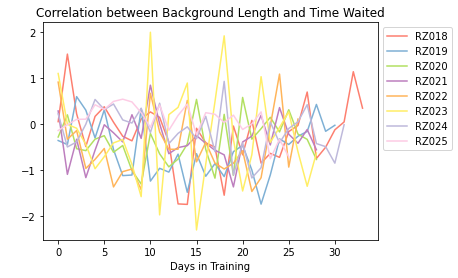

In [147]:
# plot the difference in time waited bewteen long and short blocks over days. good trials only
plot_each_mouse_per_line(data_df=linear_fit_df, 
                         column_name='slope', 
                         plot_name="tb_tw_correlation", 
                         title='Correlation between Background Length and Time Waited',
                         x_label='Days in Training', 
                         y_label=' ')

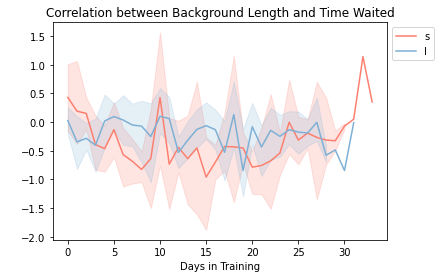

In [148]:
plot_overdays_colored_by_group(data_df=linear_fit_df, 
                               column_name="slope", 
                               plot_name='tb_tw_correlation_by_group', 
                               title='Correlation between Background Length and Time Waited', 
                               x_label='Days in Training', 
                               y_label=' ')

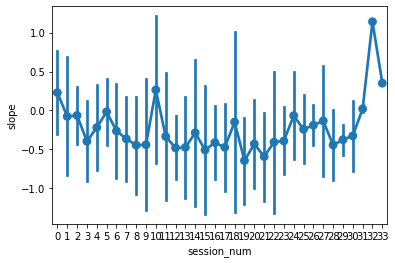

In [149]:
fig = plt.figure()
sns.pointplot(x="session_num", 
              y="slope", 
              errorbar='sd', 
              data=linear_fit_df)
fig.savefig(f'{figure_folder}/tb_tw_correlation_all_mice.png', bbox_inches='tight')

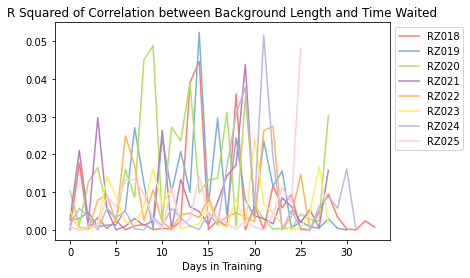

In [150]:
# plot the difference in time waited bewteen long and short blocks over days. good trials only
plot_each_mouse_per_line(data_df=linear_fit_df, 
                         column_name='rsquared', 
                         plot_name="tb_tw_correlation_rsuqared", 
                         title='R Squared of Correlation between Background Length and Time Waited',
                         x_label='Days in Training', 
                         y_label=' ')

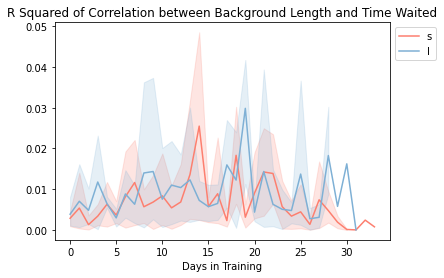

In [151]:
plot_overdays_colored_by_group(data_df=linear_fit_df, 
                               column_name="rsquared", 
                               plot_name='tb_tw_correlation_rsuqared_by_group', 
                               title='R Squared of Correlation between Background Length and Time Waited', 
                               x_label='Days in Training', 
                               y_label=' ')

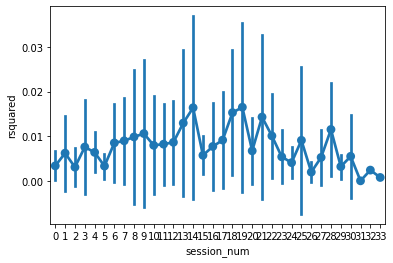

In [152]:
fig = plt.figure()
sns.pointplot(x="session_num", 
              y="rsquared", 
              errorbar='sd', 
              data=linear_fit_df)
fig.savefig(f'{figure_folder}/tb_tw_rsquared_all_mice.png', bbox_inches='tight')

## plots to be figured out

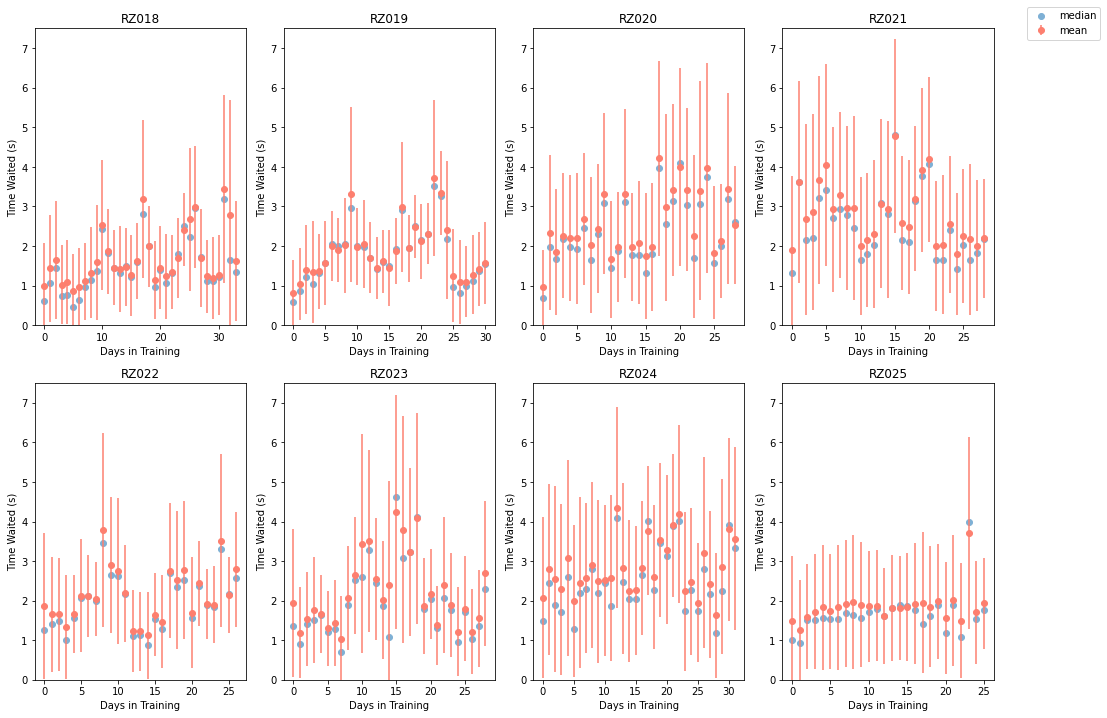

In [153]:
fig, axs = plt.subplots(2, 4, figsize=(14, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.session_num, session_mouse.tw_mean, session_mouse.tw_stdev, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.session_num, session_mouse.tw_median, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Time Waited (s)')
    ax.set_ylim(0,7.5)

handles, labels = axs[0, 0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))

plt.tight_layout()

plt.savefig(f'{figure_folder}/tw_plots.png', bbox_inches='tight', dpi=300)

plt.show()

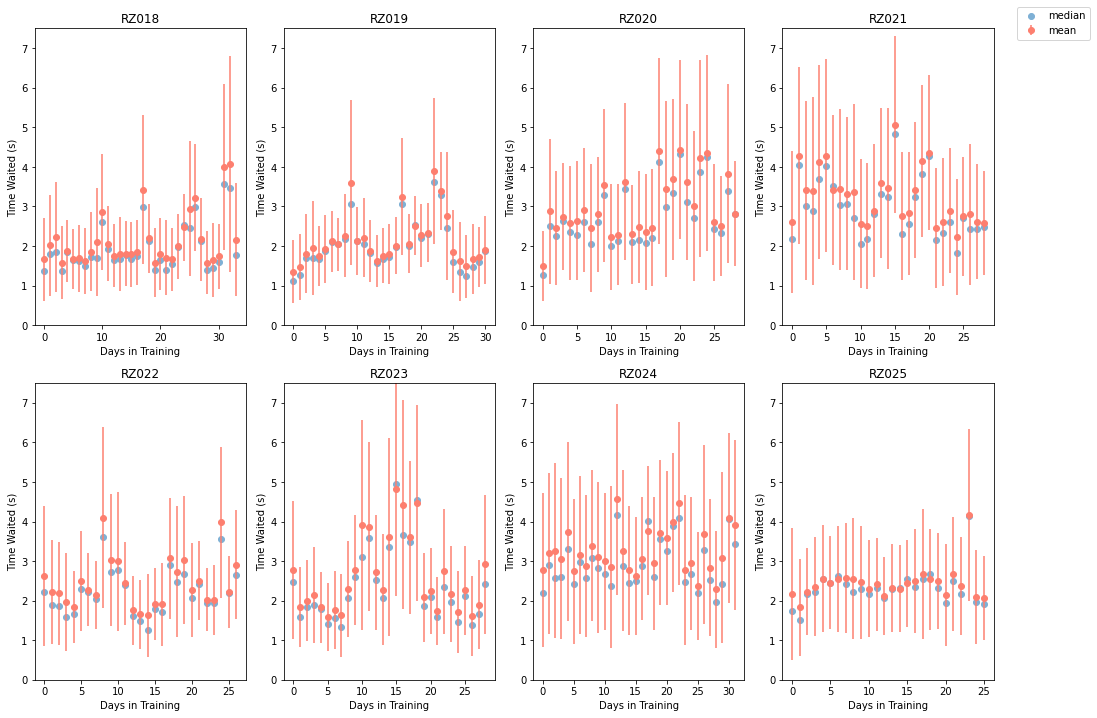

In [154]:
# Create a figure with six subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.session_num, session_mouse.tw_mean_g, session_mouse.tw_stdev_g, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.session_num, session_mouse.tw_median_g, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Time Waited (s)')
    ax.set_ylim(0,7.5)

# Extract the legend from the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()

# Set the figure legend outside the loop
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.09, 1))

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_good_plots.png', bbox_inches='tight', dpi=300)

# Show the plot (optional)
plt.show()

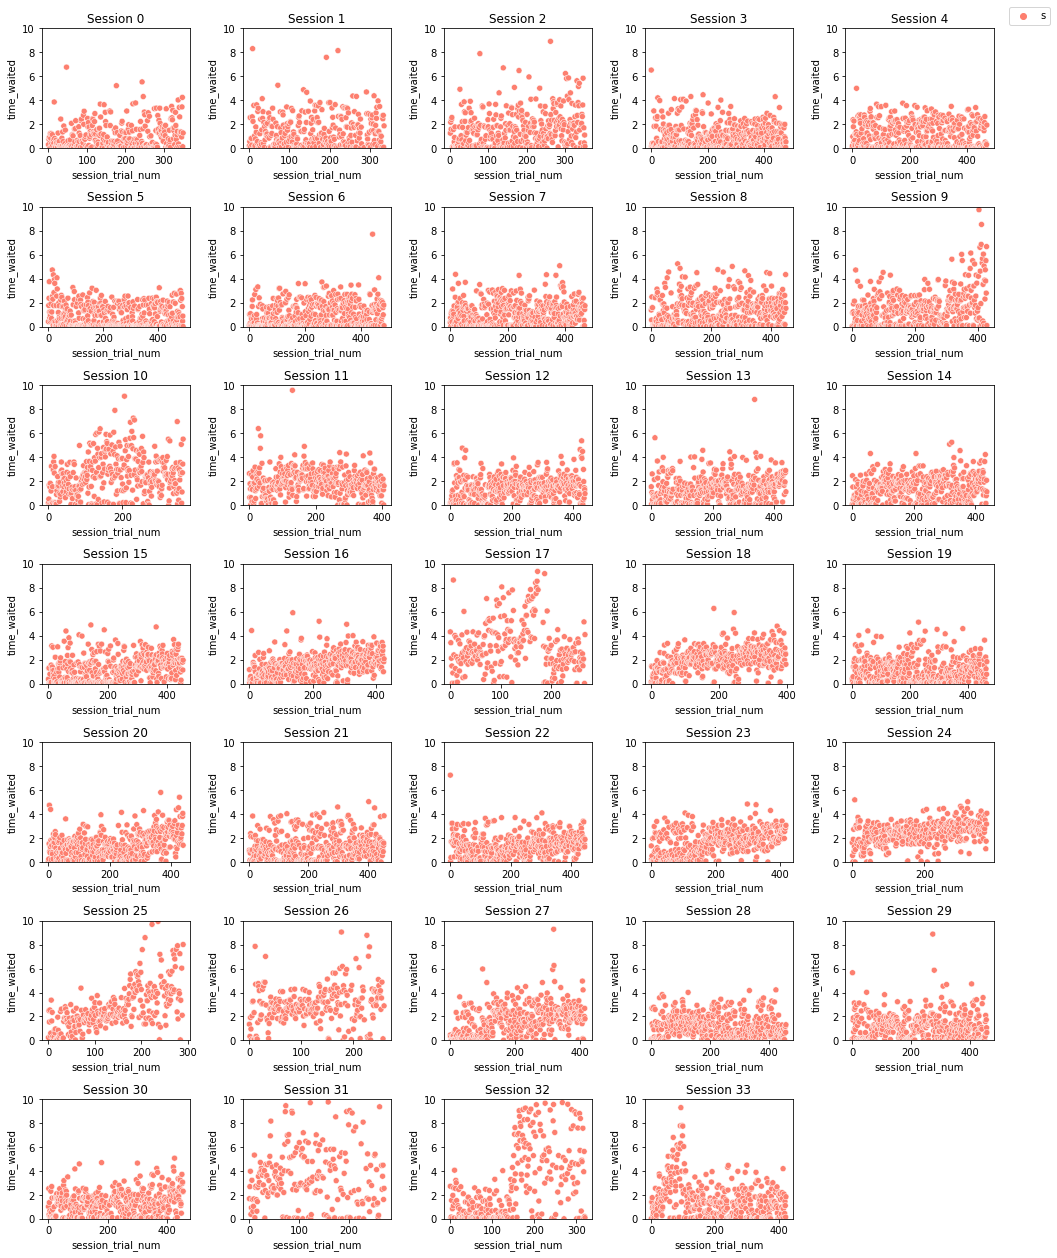

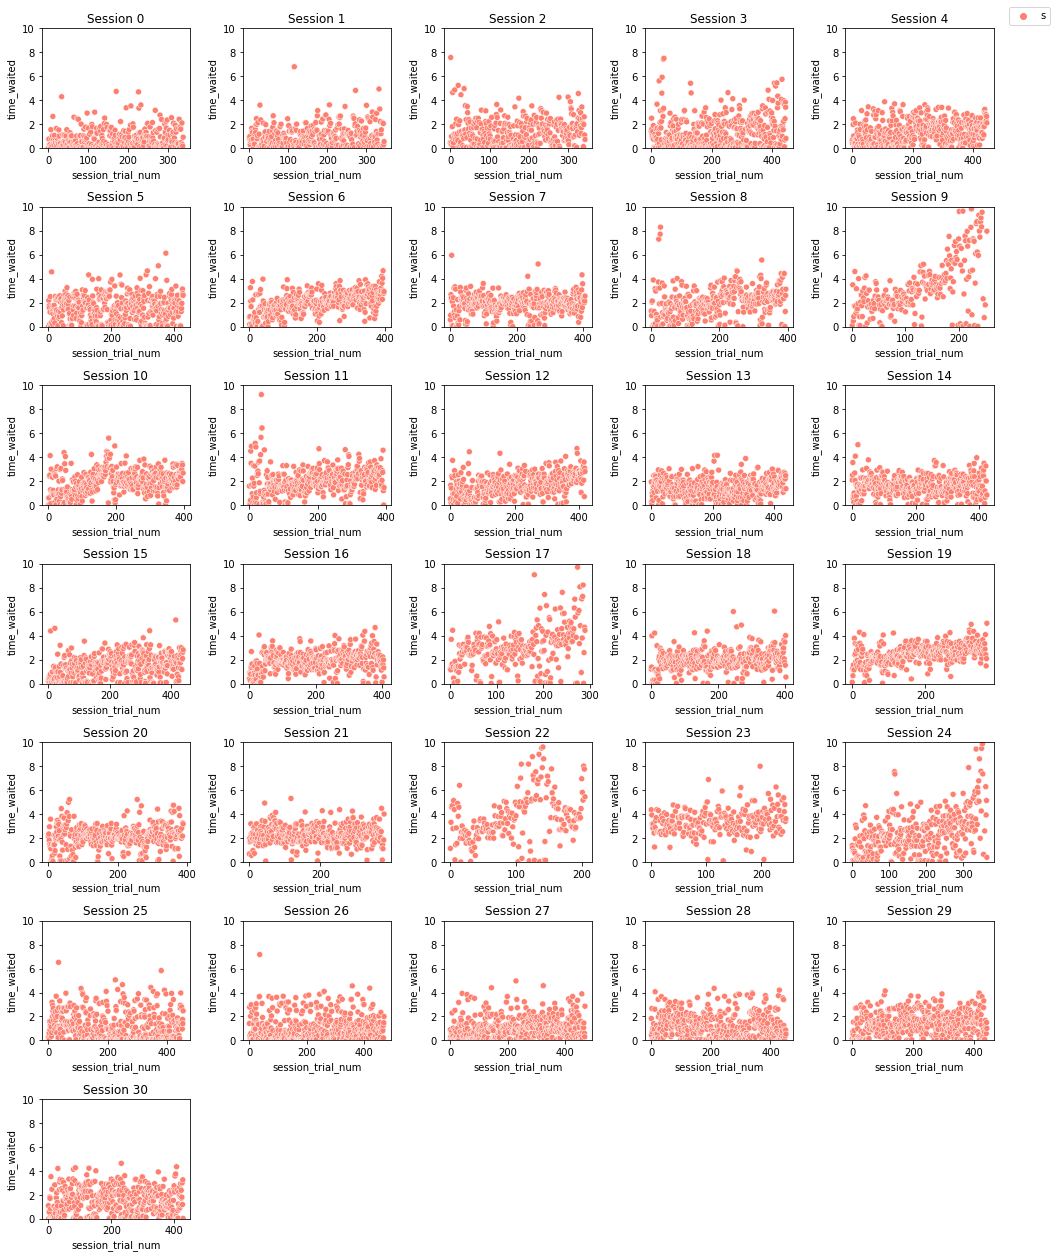

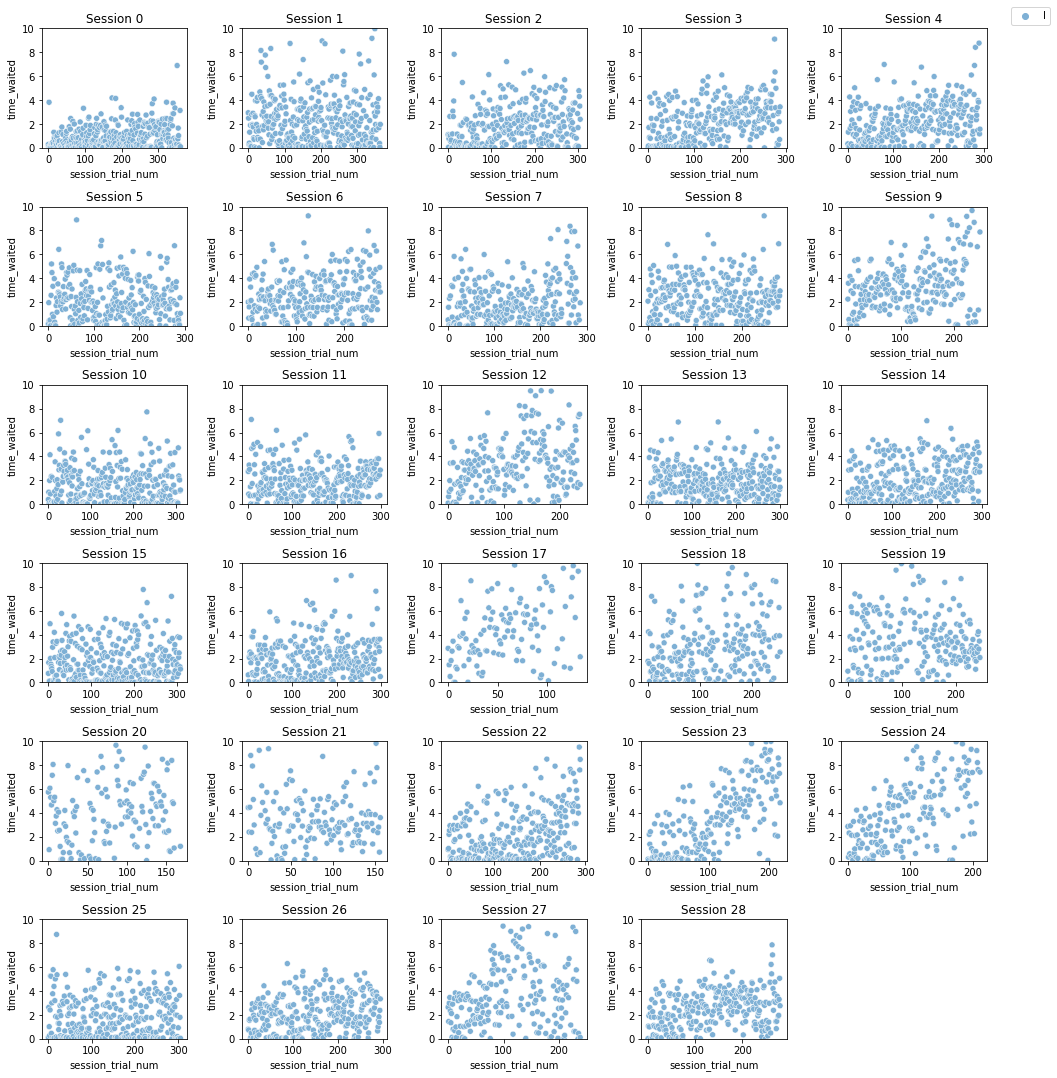

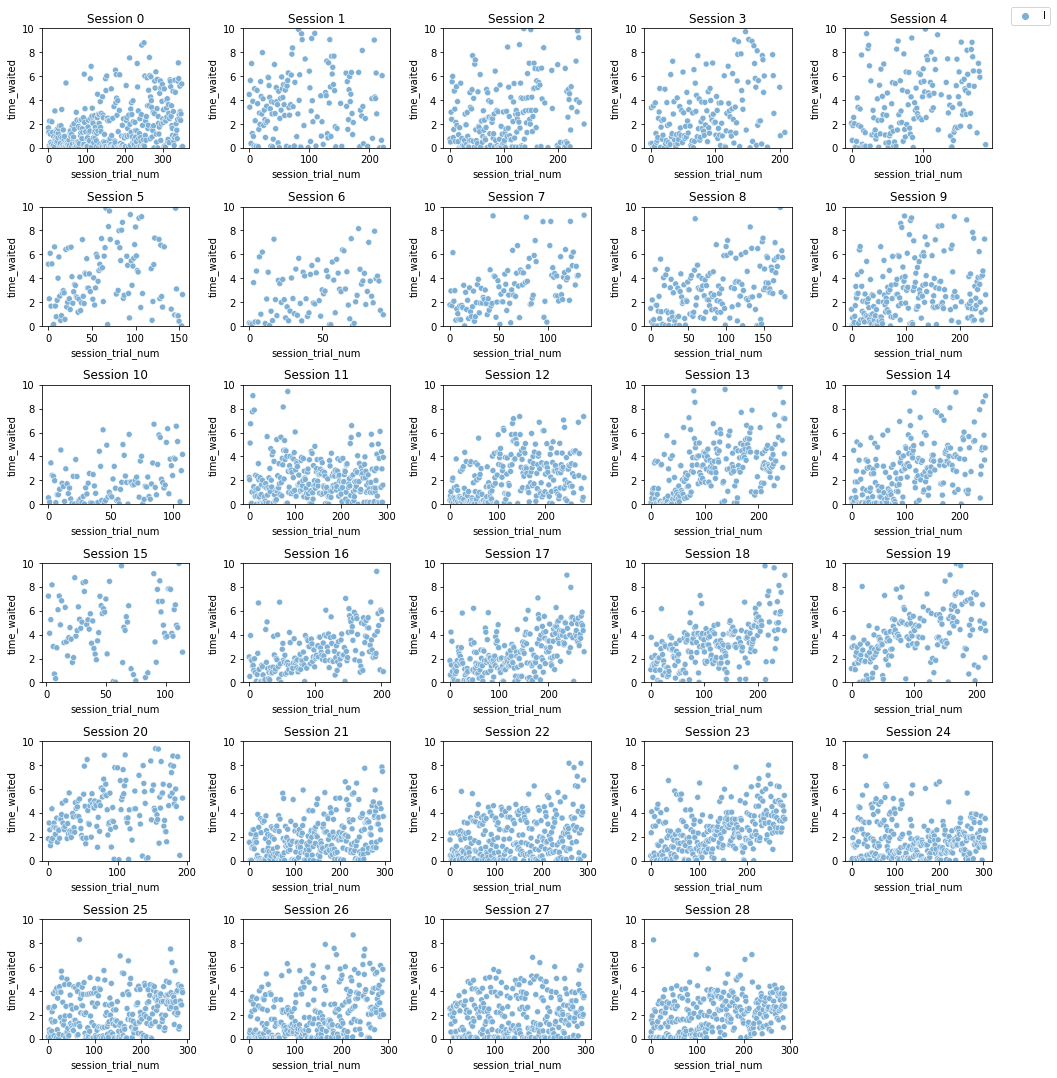

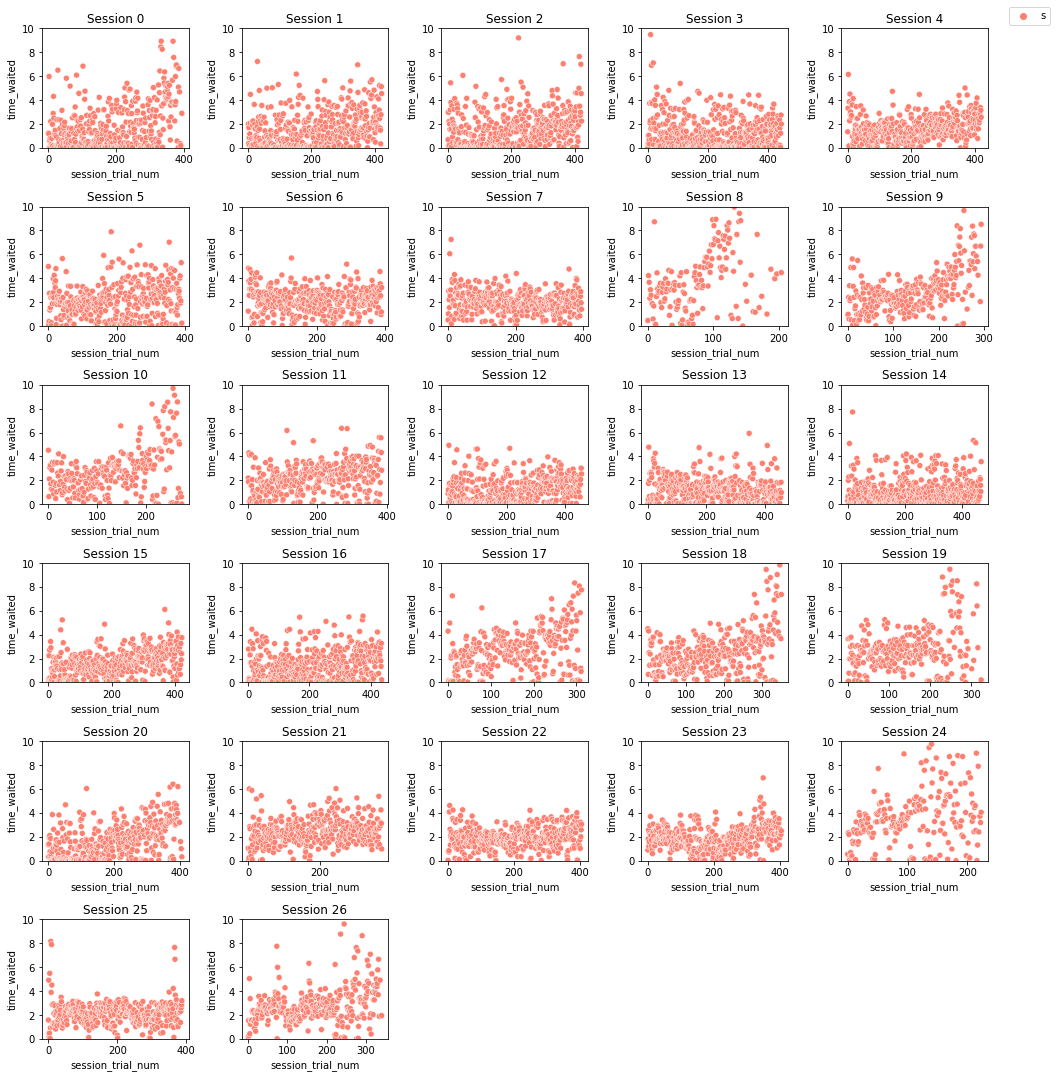

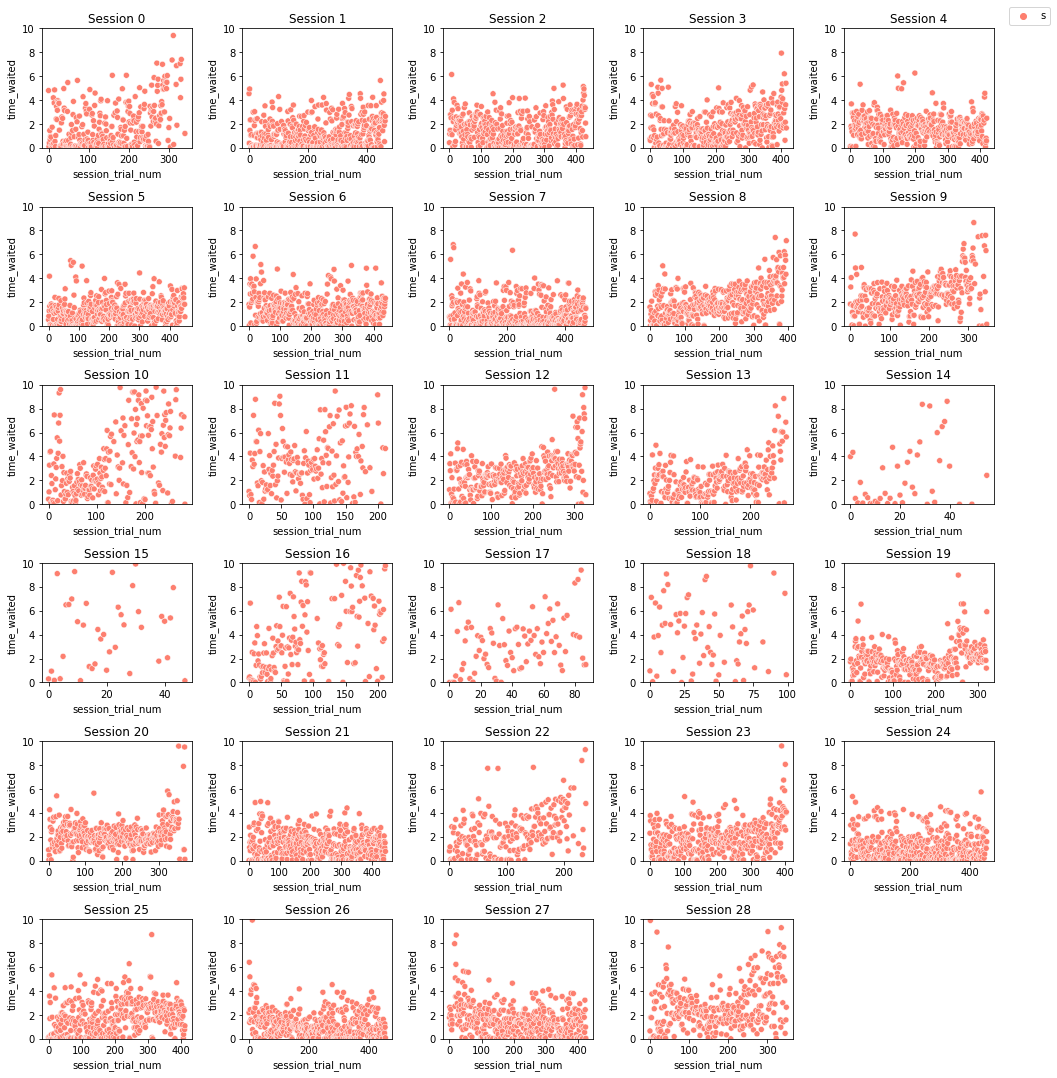

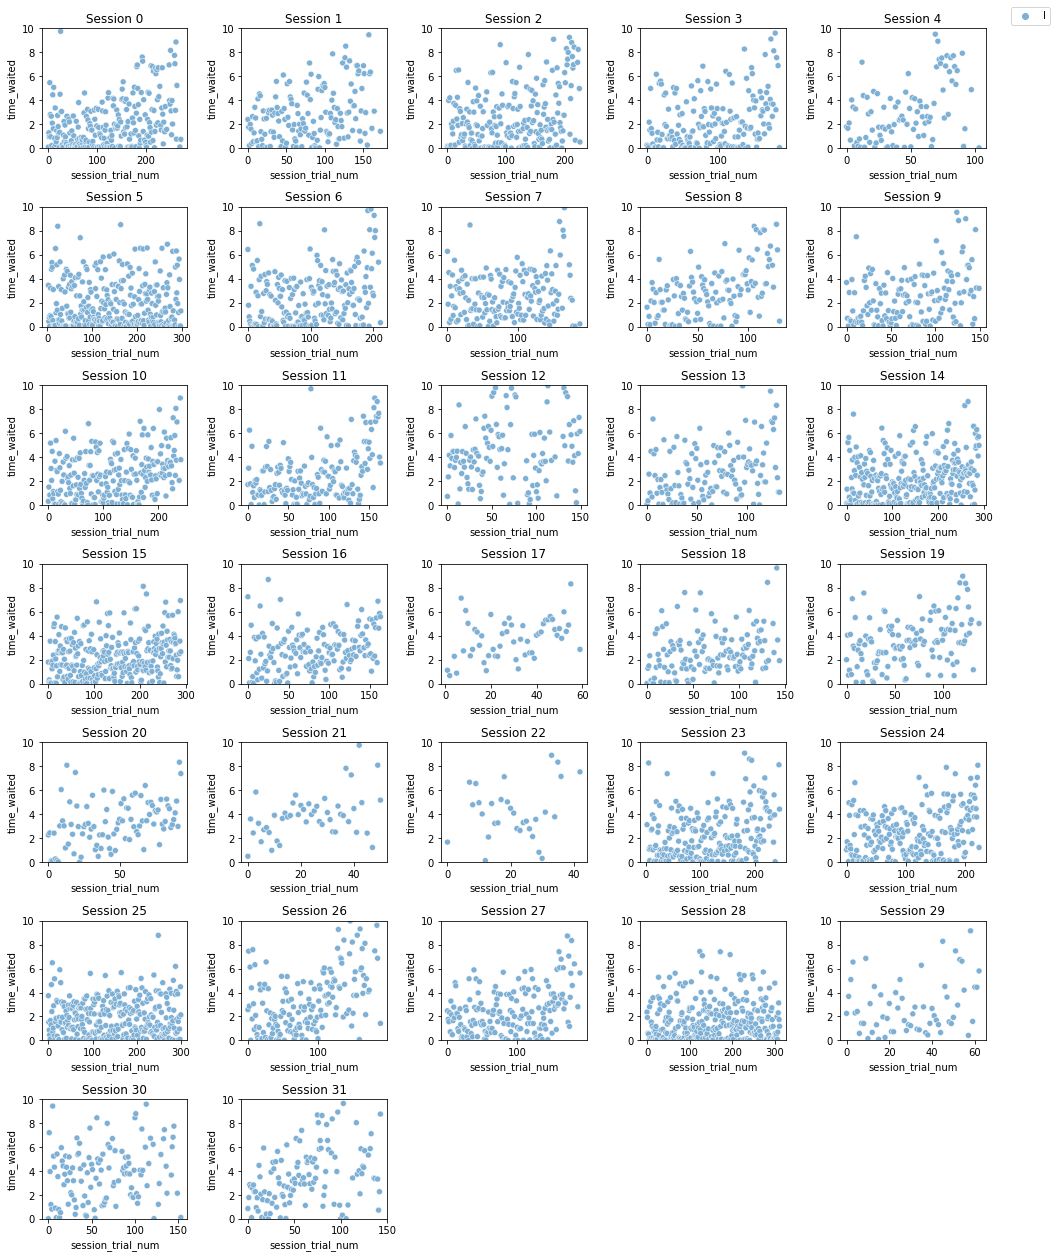

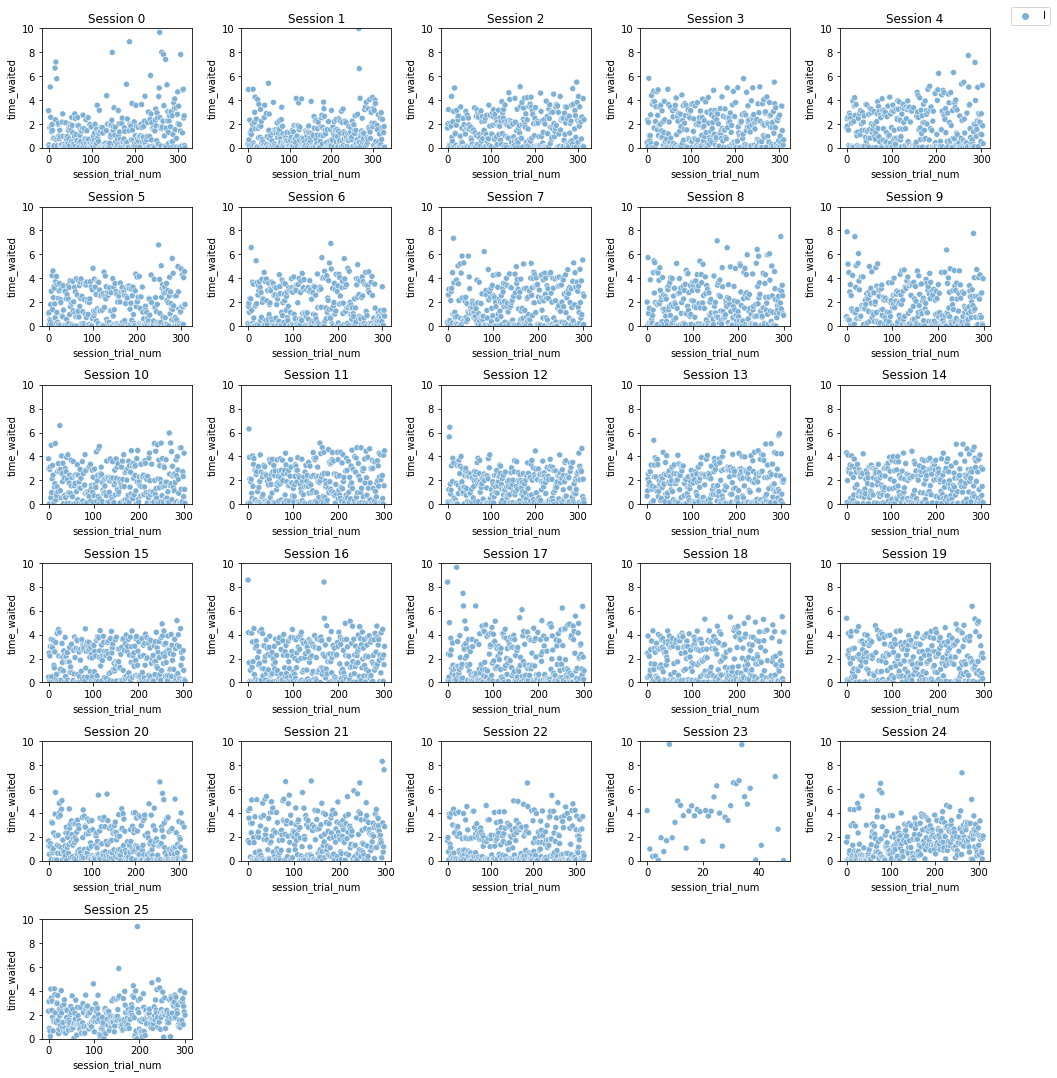

In [155]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, sess) in enumerate(zip(session_mouse.dir, session_mouse.session_num)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        custom_palette = {'l': colors[1], 's': colors[0]}
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Session {sess}')
        ax.set_ylim([0, 10])

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)

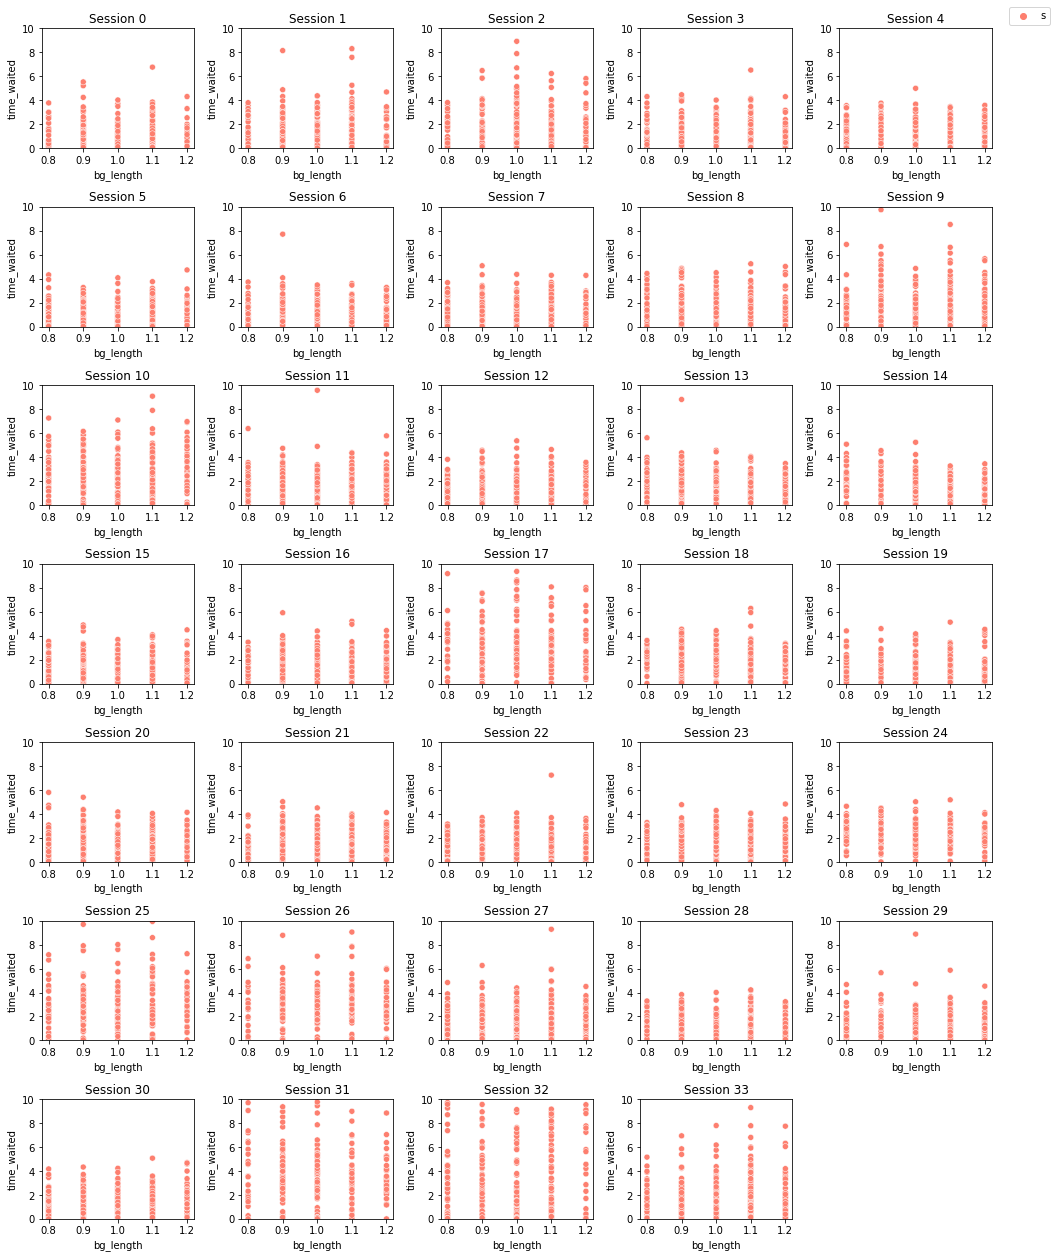

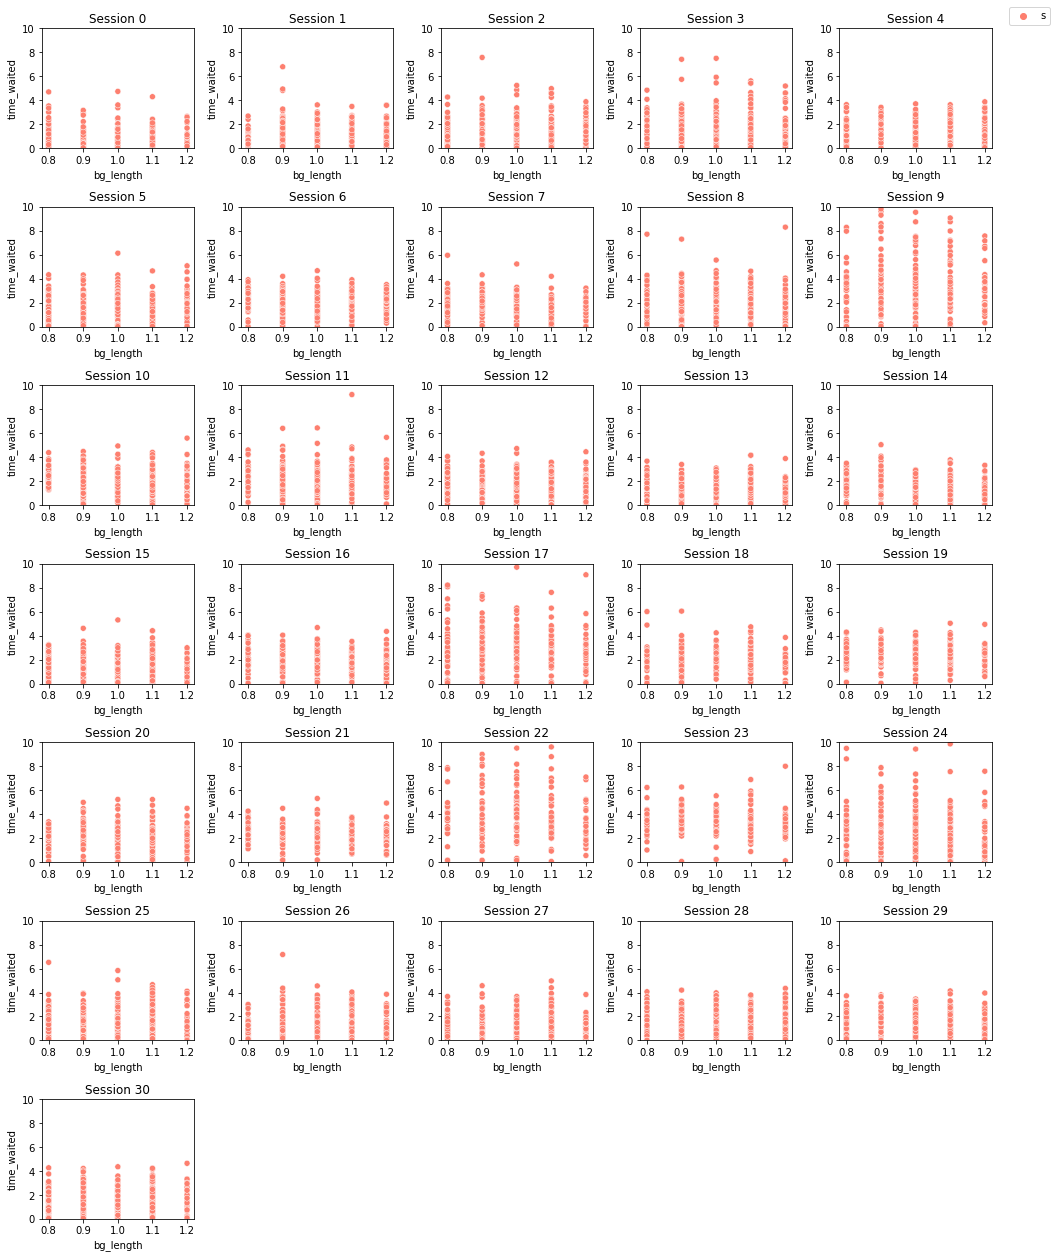

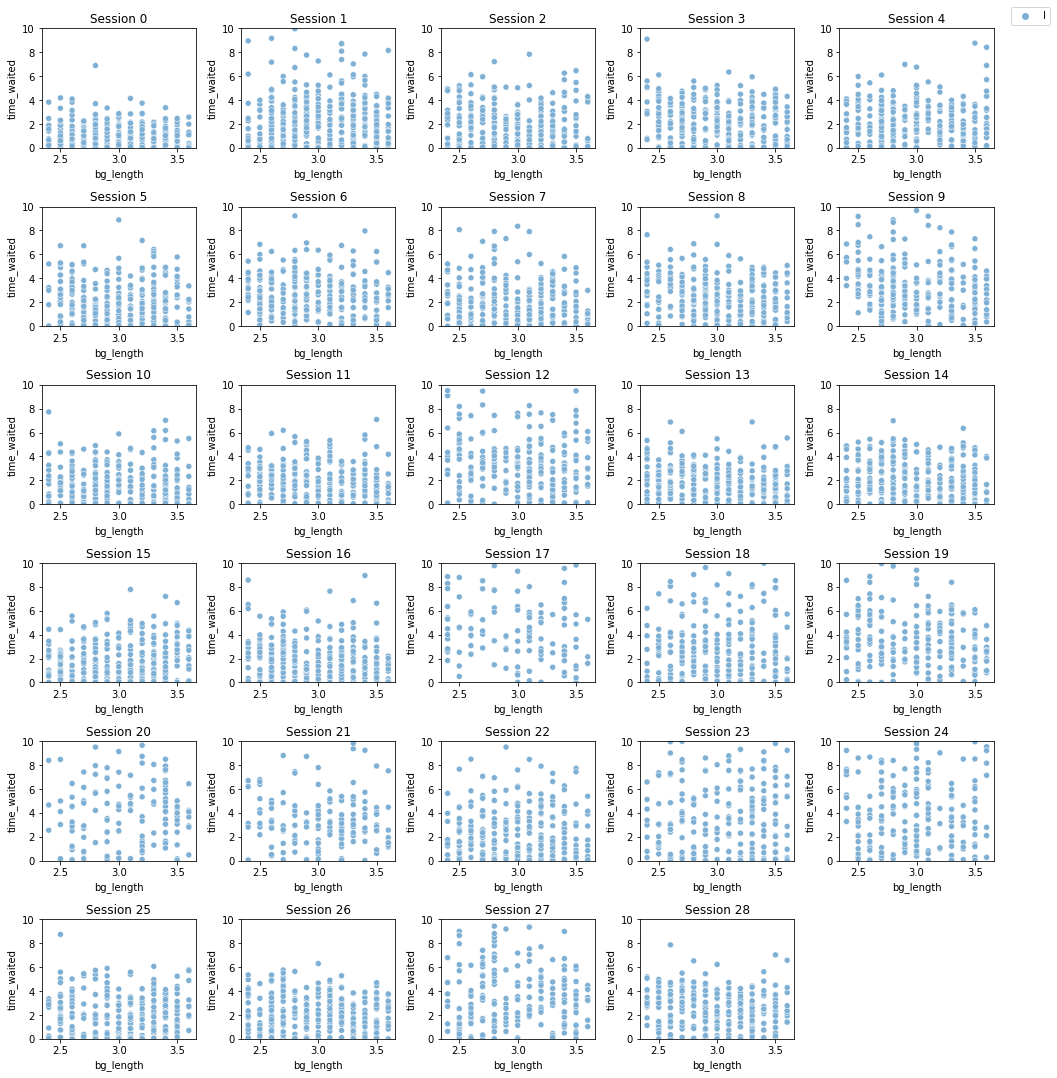

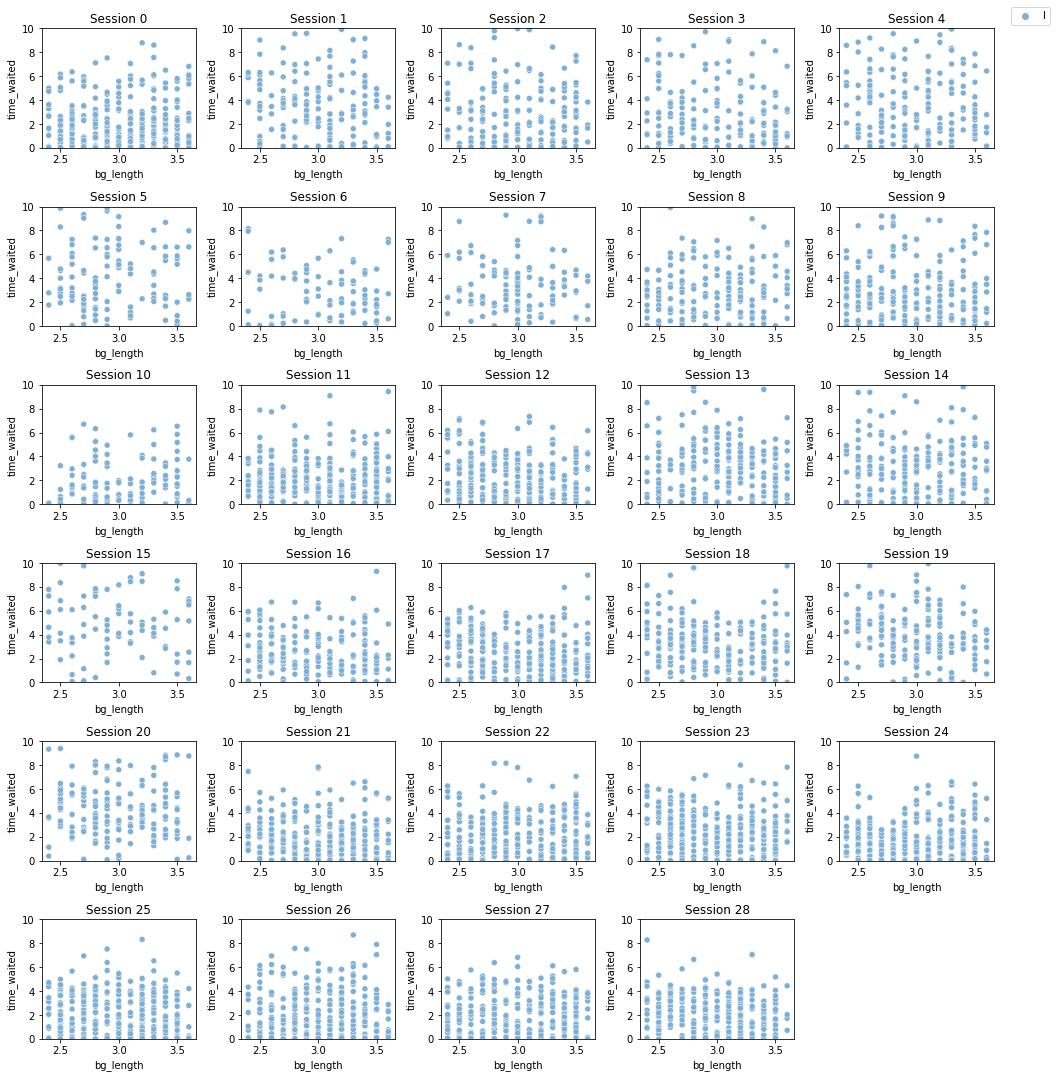

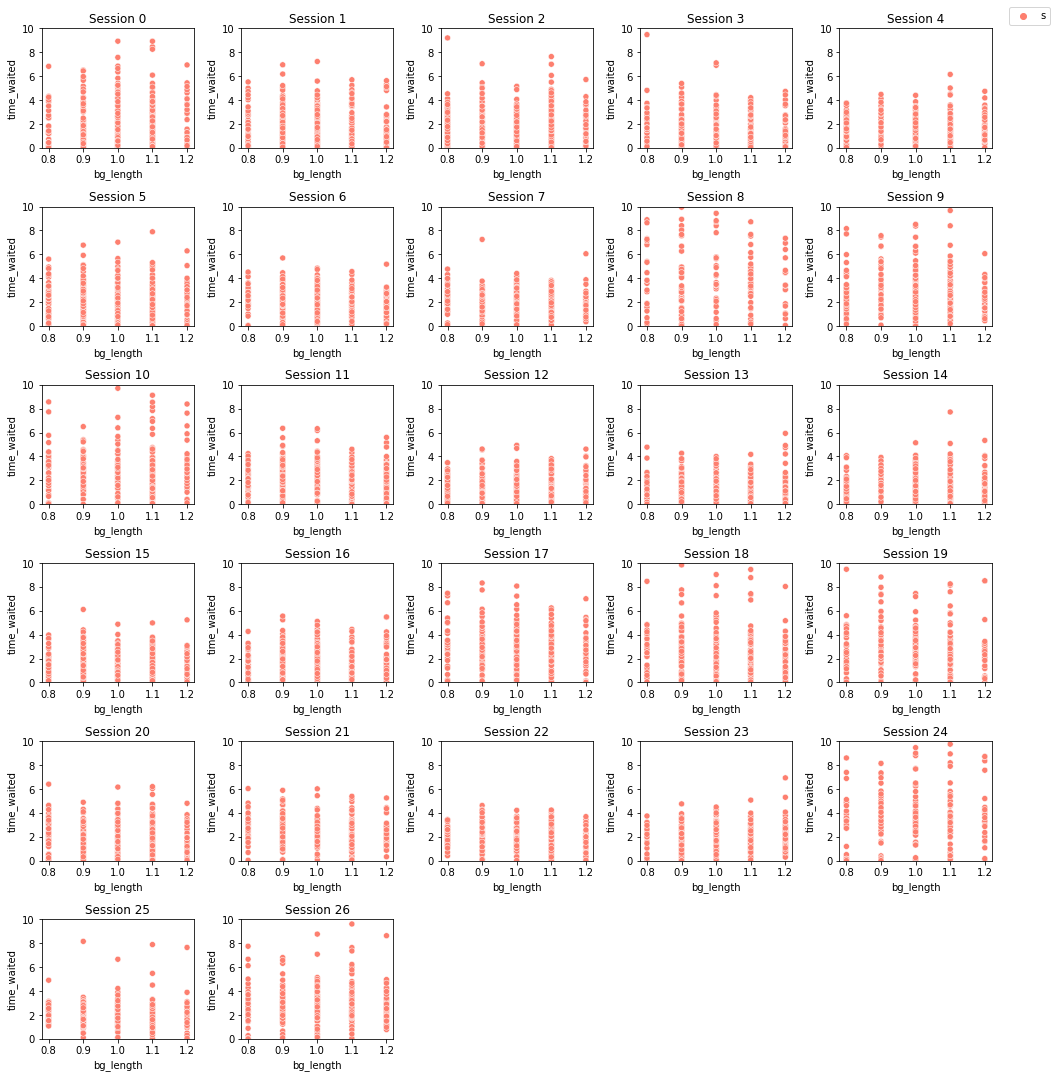

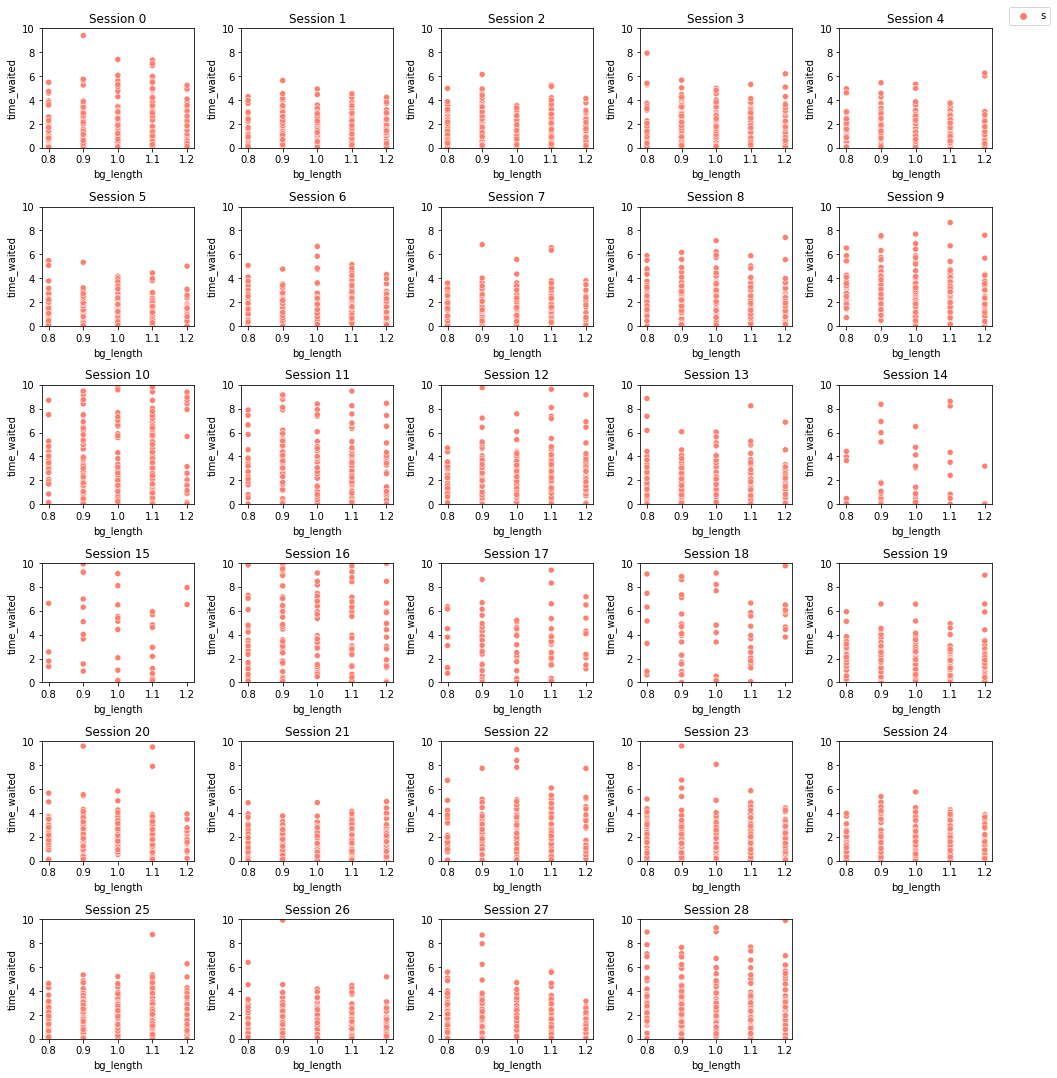

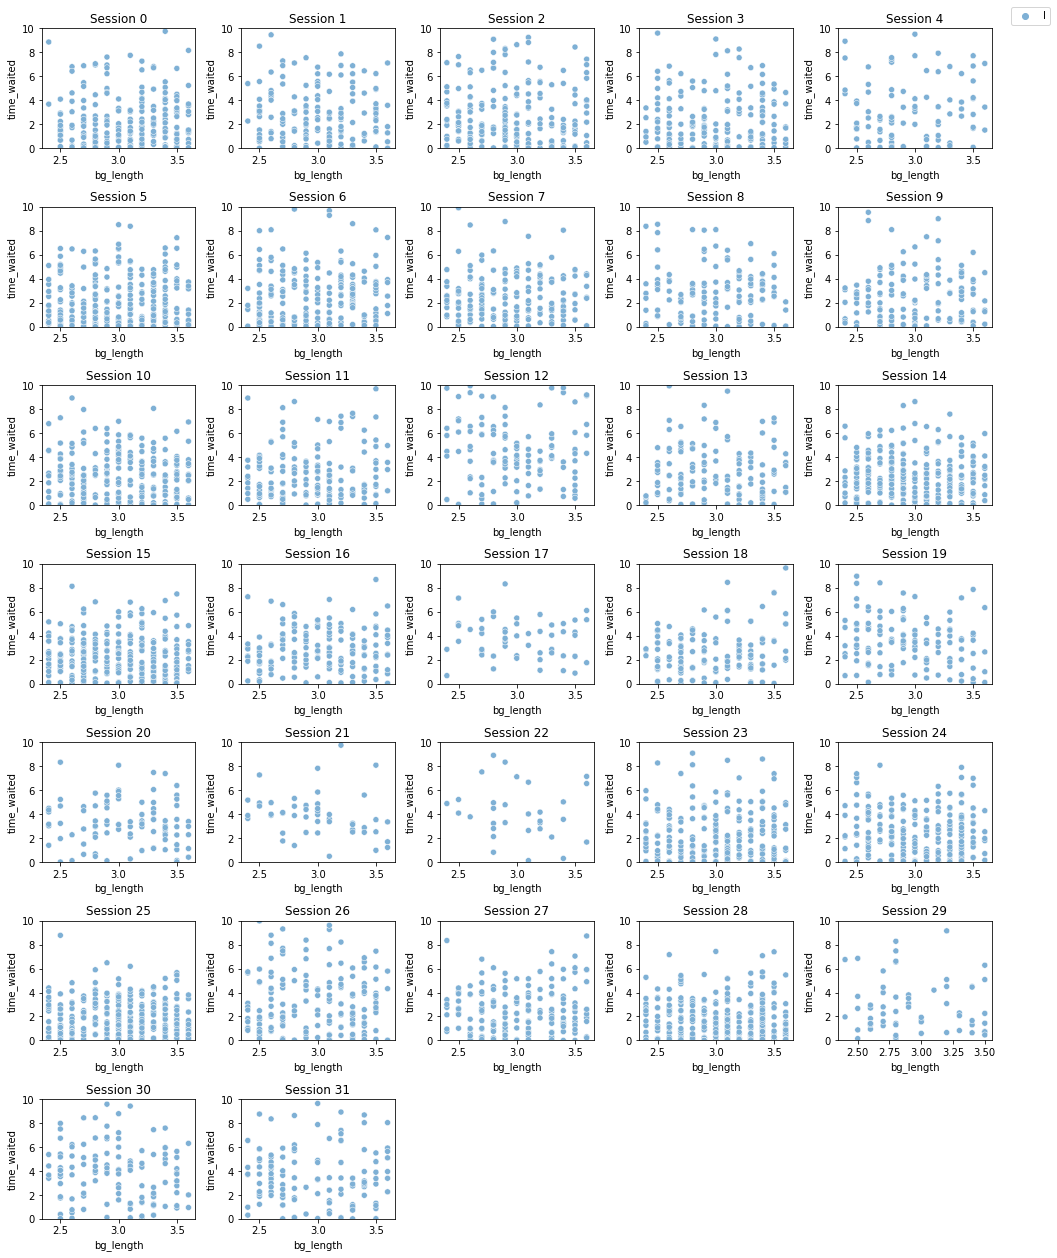

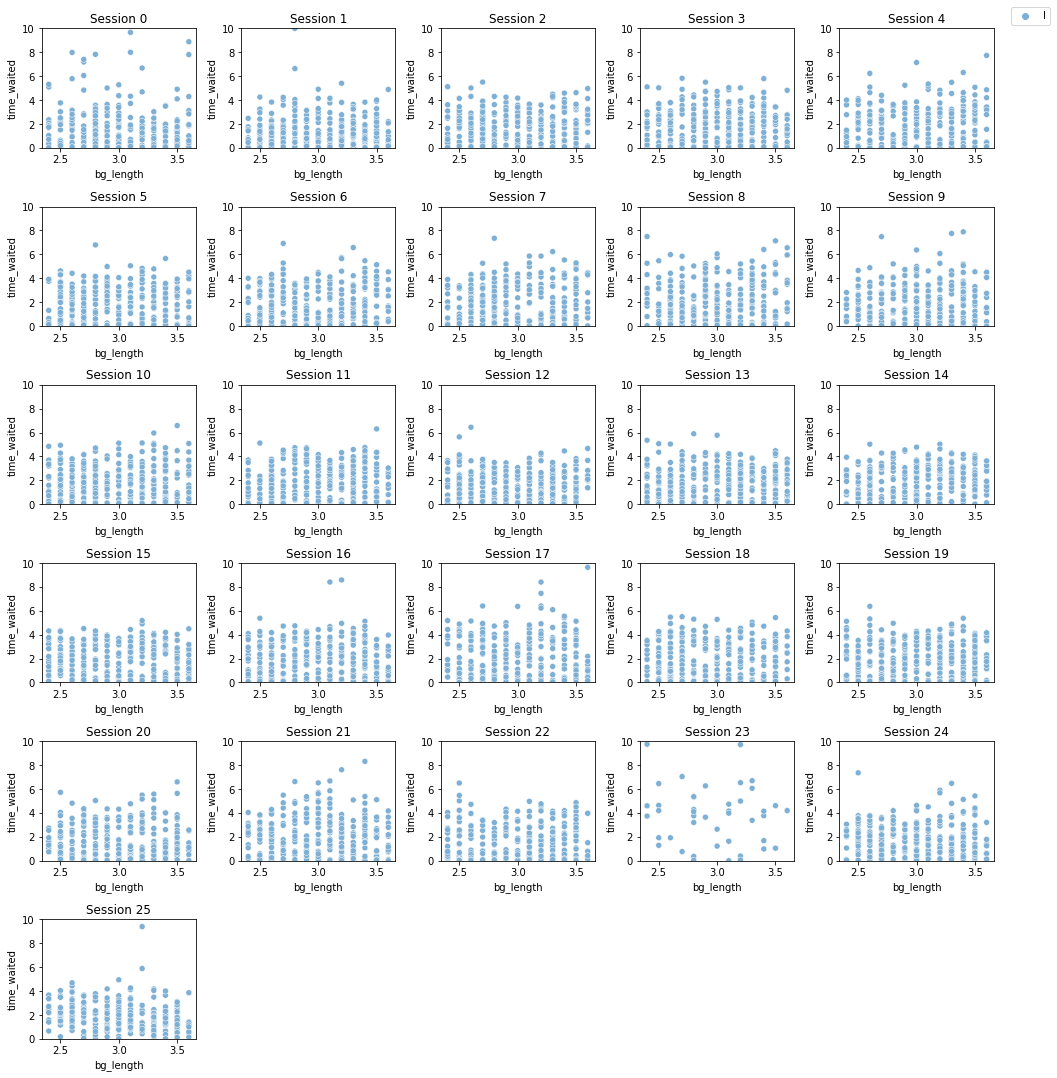

In [156]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, sess) in enumerate(zip(session_mouse.dir, session_mouse.session_num)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        custom_palette = {'l': colors[1], 's': colors[0]}
        
        sns.scatterplot(x="bg_length",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Session {sess}')
        ax.set_ylim([0, 10])

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)